In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.settings import *
import pickle as pkl
import gzip
from src.tools.vis_utils import VisualizationConfig, FIGSIZE, visualize_dendrogram, plot_hexagons_map, plot_clusters, ensure_geometry_type
from src.tools.dim_reduction import reduce_umap, reduce_tsne
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import dataclasses
import json5 as json
from scipy.cluster.hierarchy import cut_tree
from src.tools.configs import ExperimentConfig
from src.tools.clustering import remap_cluster
from src.tools.feature_extraction import features_wide_to_long
from sklearn.metrics import pairwise_distances_argmin
from tqdm.auto import tqdm
import seaborn as sns
import plotly.express as px
import numpy as np
from IPython.display import display
import contextily as ctx

In [3]:
run_name = "rose-sun-44"
run_dir = RUNS_DATA_DIR / run_name

with gzip.open(run_dir / "dataset.pkl.gz", "rb") as f:
    ds = pkl.load(f)

z_df = pd.read_pickle(run_dir / "embeddings.pkl.gz")
input_df = pd.read_pickle(run_dir / "input.pkl.gz")

In [4]:
ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'edges_feature_selected': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [5]:
z_df

z_0       z_1       z_2  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5106993ffff  0.342066  0.428381  0.087947   
                            891f5106993ffff  0.044766  0.683336  0.046412   
                            891f5106d67ffff  0.044766  0.683336  0.046412   
                            891f5106997ffff  0.063998  0.585682 -0.102041   
                            891f5106993ffff  0.063998  0.585682 -0.102041   
...                                               ...       ...       ...   
                  Łódź      891e2186aafffff  0.290721 -0.194353 -0.152859   
                            891e2186a33ffff  0.290721 -0.194353 -0.152859   
                            891e2186a33ffff  0.348859 -0.001323 -0.094344   
                            891e2186a33ffff  0.348859 -0.001323 -0.094344   
                            891e2186aafffff  0.348859 -0.001323 -0.094344   

                                                  z_3       z_4       z_5  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5106993ffff -0.603112 -0.395545  0.603423   
                            891f5106993ffff -0.702277 -0.355882  0.347337   
                            891f5106d67ffff -0.702277 -0.355882  0.347337   
                            891f5106997ffff -0.796996 -0.292700  0.266813   
                            891f5106993ffff -0.796996 -0.292700  0.266813   
...                                               ...       ...       ...   
                  Łódź      891e2186aafffff  0.051254 -0.573223  0.109253   
                            891e2186a33ffff  0.051254 -0.573223  0.109253   
                            891e2186a33ffff  0.141564 -0.424439 -0.264807   
                            891e2186a33ffff  0.141564 -0.424439 -0.264807   
                            891e2186aafffff  0.141564 -0.424439 -0.264807   

                                                  z_6       z_7       z_8  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5106993ffff -1.186571  0.789628 -0.274625   
                            891f5106993ffff -0.238845  0.308295  0.332662   
                            891f5106d67ffff -0.238845  0.308295  0.332662   
                            891f5106997ffff -0.442069  0.258601  0.344373   
                            891f5106993ffff -0.442069  0.258601  0.344373   
...                                               ...       ...       ...   
                  Łódź      891e2186aafffff -1.133735  0.410644 -0.223926   
                            891e2186a33ffff -1.133735  0.410644 -0.223926   
                            891e2186a33ffff -0.586222 -0.077301  0.041692   
                            891e2186a33ffff -0.586222 -0.077301  0.041692   
                            891e2186aafffff -0.586222 -0.077301  0.041692   

                                                  z_9  ...      z_20  \
continent country city      h3_id                      ...             
Europe    Poland  Białystok 891f5106993ffff  0.696226  ... -0.766874   
                            891f5106993ffff  0.284348  ... -0.546090   
                            891f5106d67ffff  0.284348  ... -0.546090   
                            891f5106997ffff  0.295771  ... -0.217529   
                            891f5106993ffff  0.295771  ... -0.217529   
...                                               ...  ...       ...   
                  Łódź      891e2186aafffff  0.081291  ...  0.142493   
                            891e2186a33ffff  0.081291  ...  0.142493   
                            891e2186a33ffff  0.134877  ...  0.015419   
                            891e2186a33ffff  0.134877  ...  0.015419   
                            891e2186aafffff  0.134877  ...  0.015419   

                                                 z_21      z_22      z_23  \
continent country city      h3

In [6]:
with open(run_dir / "experiment_config.json", "r") as f:
    ec_json = json.load(f)
    ec = ExperimentConfig(**ec_json)
ec

ExperimentConfig(dataset_filename='dataset_2022-01-04_20-41-53_poland.pkl.gz', model_name='autoencoder', mode='edges', test_cities=[], test_size=0.2, random_seed=42, batch_size=200, num_workers=3, shuffle=True, hidden_dim=64, enc_out_dim=40, latent_dim=30, epochs=50, kl_coeff=0.1, lr=0.001)

In [7]:
if ec.mode == "edges":
    z_df_edges = z_df
    z_df = z_df.groupby(level=[0, 1, 2, 3]).mean()

    input_df_edges = input_df
    input_df = input_df.groupby(level=[0, 1, 2, 3]).sum()
    input_df_mean = input_df_edges.groupby(level=[0, 1, 2, 3]).mean()


In [8]:
z_df

z_0       z_1       z_2  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff  0.105459  0.485647  0.060334   
                            891f5104d2bffff  0.462417  0.338800  0.026129   
                            891f5104d37ffff  0.250927  0.186240 -0.069000   
                            891f5104da7ffff  0.451818  0.111140  0.251220   
                            891f5104db7ffff  0.138427  0.208027  0.214268   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.361085 -0.114209 -0.184200   
                            891f5249babffff  0.393954  0.023222 -0.123309   
                            891f5249bafffff  0.346834 -0.047206 -0.119023   
                            891f5249bb3ffff  0.328914 -0.017214 -0.124593   
                            891f5249bb7ffff  0.338041 -0.071825 -0.140928   

                                                  z_3       z_4       z_5  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff -0.085838 -0.446157  0.078250   
                            891f5104d2bffff -0.047096 -0.412656  0.413347   
                            891f5104d37ffff -0.242506 -0.346692  0.179084   
                            891f5104da7ffff -0.233724 -0.099736 -0.049473   
                            891f5104db7ffff -0.059154 -0.082445 -0.019271   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff  0.017465 -0.423862 -0.164949   
                            891f5249babffff  0.042827 -0.232701 -0.299262   
                            891f5249bafffff  0.081171 -0.252411 -0.310986   
                            891f5249bb3ffff  0.080854 -0.246402 -0.311647   
                            891f5249bb7ffff  0.032799 -0.112352 -0.348310   

                                                  z_6       z_7       z_8  \
continent country city      h3_id                                           
Europe    Poland  Białystok 891f5104d23ffff -0.417931  0.616665 -0.234479   
                            891f5104d2bffff -0.280526  0.056869 -0.364861   
                            891f5104d37ffff -0.249456  0.811066 -0.205631   
                            891f5104da7ffff -0.271298  0.076505  0.009673   
                            891f5104db7ffff -0.344104 -0.113428  0.172007   
...                                               ...       ...       ...   
                  Łódź      891f5249ba7ffff -0.577549 -0.000061  0.161067   
                            891f5249babffff -0.623875  0.107879  0.180608   
                            891f5249bafffff -0.591664  0.003025  0.139568   
                            891f5249bb3ffff -0.595778  0.018937  0.141503   
                            891f5249bb7ffff -0.597613  0.073482  0.218673   

                                                  z_9  ...      z_20  \
continent country city      h3_id                      ...             
Europe    Poland  Białystok 891f5104d23ffff -0.015324  ... -0.583364   
                            891f5104d2bffff -0.195521  ... -0.111303   
                            891f5104d37ffff  0.118934  ... -0.897902   
                            891f5104da7ffff -0.030250  ... -0.226087   
                            891f5104db7ffff -0.177396  ... -0.188112   
...                                               ...  ...       ...   
                  Łódź      891f5249ba7ffff  0.271538  ... -0.080928   
                            891f5249babffff  0.306637  ... -0.071756   
                            891f5249bafffff  0.276762  ... -0.029629   
                            891f5249bb3ffff  0.268272  ... -0.039156   
                            891f5249bb7ffff  0.386854  ... -0.069442   

                                                 z_21      z_22      z_23  \
continent country city      h3

In [9]:
vc = VisualizationConfig(
    n_clusters=None,
    distance_threshold=0,
    affinity="euclidean",
    linkage="ward",
    truncate_mode="level",
    p=5,
    clusters=[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    cities_to_plot=["Wrocław", "Bydgoszcz", "Trójmiasto", "Warszawa"],
    # cities_to_plot=["Wrocław"],
    umap_n_components=2,
    umap_n_neighbours=30,
    umap_metric="euclidean",
    tsne_perplexity=100,
)

vis_dir = run_dir / "vis"
vis_dir.mkdir(parents=True, exist_ok=True)

with open(vis_dir / "vis_config.json", "w") as f:
    json.dump(dataclasses.asdict(vc), f, indent=2, quote_keys=True, trailing_commas=False)

In [10]:
feature_keys = list(ds.config.featureset_selection["features"].keys())
feature_keys

['oneway',
 'lanes',
 'highway',
 'maxspeed',
 'bridge',
 'access',
 'junction',
 'width',
 'tunnel',
 'surface']

In [11]:
edges_fs_long = features_wide_to_long(ds.edges_feature_selected.assign(geometry=ds.edges["geometry"]), feature_keys)
edges_fs_long

geometry  \
continent country city      h3_id                                                                
Europe    Poland  Białystok 891f5106993ffff  LINESTRING (23.10751 53.14003, 23.10740 53.139...   
                            891f5106993ffff  LINESTRING (23.10751 53.14003, 23.10728 53.140...   
                            891f5106d67ffff  LINESTRING (23.10751 53.14003, 23.10728 53.140...   
                            891f5106997ffff  LINESTRING (23.10817 53.13987, 23.10799 53.139...   
                            891f5106993ffff  LINESTRING (23.10817 53.13987, 23.10799 53.139...   
...                                                                                        ...   
                  Łódź      891e2186aafffff  LINESTRING (19.35522 51.79957, 19.35516 51.798...   
                            891e2186a33ffff  LINESTRING (19.35522 51.79957, 19.35516 51.798...   
                            891e2186a33ffff  LINESTRING (19.35423 51.79942, 19.35436 51.799...   
                            891e2186a33ffff  LINESTRING (19.35423 51.79942, 19.35522 51.79957)   
                            891e2186aafffff  LINESTRING (19.35423 51.79942, 19.35522 51.79957)   

                                                   oneway    lanes  \
continent country city      h3_id                                    
Europe    Poland  Białystok 891f5106993ffff   oneway_True  lanes_5   
                            891f5106993ffff   oneway_True  lanes_2   
                            891f5106d67ffff   oneway_True  lanes_2   
                            891f5106997ffff   oneway_True  lanes_4   
                            891f5106993ffff   oneway_True  lanes_4   
...                                                   ...      ...   
                  Łódź      891e2186aafffff  oneway_False      NaN   
                            891e2186a33ffff  oneway_False      NaN   
                            891e2186a33ffff  oneway_False      NaN   
                            891e2186a33ffff  oneway_False      NaN   
                            891e2186aafffff  oneway_False      NaN   

                                                         highway     maxspeed  \
continent country city      h3_id                                               
Europe    Poland  Białystok 891f5106993ffff    highway_secondary  maxspeed_50   
                            891f5106993ffff    highway_secondary  maxspeed_50   
                            891f5106d67ffff    highway_secondary  maxspeed_50   
                            891f5106997ffff    highway_secondary  maxspeed_50   
                            891f5106993ffff    highway_secondary  maxspeed_50   
...                                                          ...          ...   
                  Łódź      891e2186aafffff  highway_residential          NaN   
                            891e2186a33ffff  highway_residential          NaN   
                            891e2186a33ffff  highway_residential          NaN   
                            891e2186a33ffff  highway_residential          NaN   
                            891e2186aafffff  highway_residential          NaN   

                                            bridge access junction width  \
continent country city      h3_id                                          
Europe    Poland  Białystok 891f5106993ffff    NaN    NaN      NaN   NaN   
                            891f5106993ffff    NaN    NaN      NaN   NaN   
                            891f5106d67ffff    NaN    NaN      NaN   NaN   
                            891f5106997ffff    NaN    NaN      NaN   NaN   
                            891f5106993ffff    NaN    NaN      NaN   NaN   
...                                            ...    ...      ...   ...   
                  Łódź      891e2186aafffff    NaN    NaN      NaN   NaN   
                            891e2186a33ffff    NaN    NaN      NaN   NaN   
                            891e2186a33ffff    NaN    NaN      NaN   NaN   
          

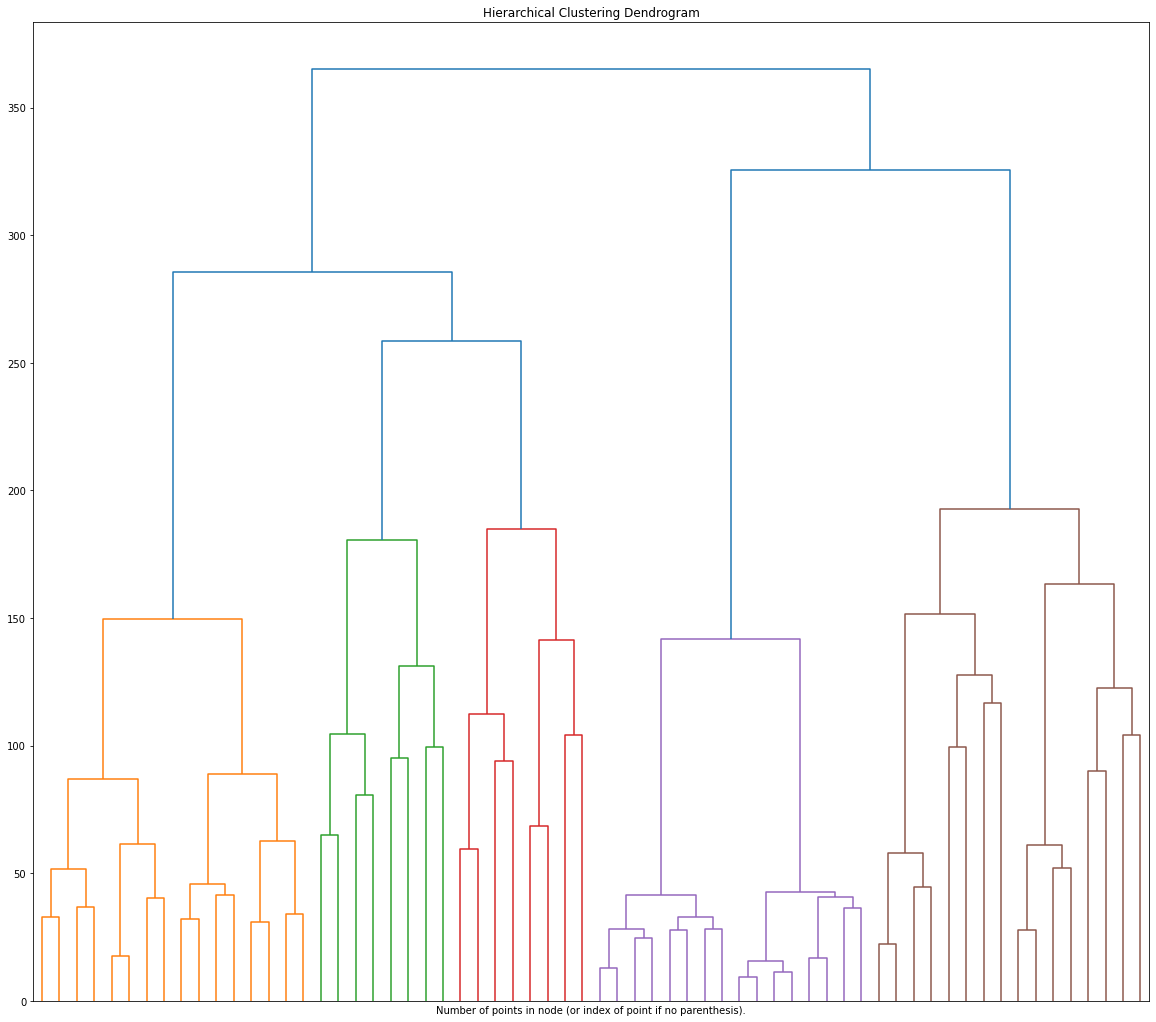

In [12]:
dendrogram_path = vis_dir / "dendrogram.png"

ac_model = AgglomerativeClustering(n_clusters=vc.n_clusters, distance_threshold=vc.distance_threshold, affinity=vc.affinity, linkage=vc.linkage)
# ac_model = AgglomerativeClustering(n_clusters=vc.n_clusters, distance_threshold=vc.distance_threshold, affinity="cosine", linkage="average")  # use with_std=False in StandardScaler
z_df_scaled = pd.DataFrame(StandardScaler().fit_transform(z_df), index=z_df.index, columns=z_df.columns)
ac_model.fit(z_df_scaled)
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

linkage_matrix = visualize_dendrogram(ac_model, truncate_mode=vc.truncate_mode, p=vc.p, ax=ax, no_labels=True)

fig.savefig(dendrogram_path, facecolor='w')
plt.show()

In [13]:
hexagons = ds.hexagons
z_df_with_clusters = z_df.copy()
cut_tree_results = cut_tree(linkage_matrix, n_clusters = vc.clusters)
clusters_divided = [None]
for index, c in tqdm(list(enumerate(vc.clusters))):
    assigned_clusters = cut_tree_results[:, index]
    z_df_with_clusters[f"cluster_{c}"] = pd.Series(assigned_clusters, index=z_df.index).astype("category")

    if index > 0:
        remapped_clusters, cluster_divided_id = remap_cluster(z_df_with_clusters, c=c)
        clusters_divided.append(cluster_divided_id)
        z_df_with_clusters[f"cluster_{c}"] = remapped_clusters

hexagons_clustered = hexagons.join(z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]).dropna().set_crs(epsg=4326)
# hexagons_clustered.head(3)

100%|██████████| 19/19 [00:00<00:00, 56.12it/s]


In [14]:
df_clusters = z_df_with_clusters[[f"cluster_{c}" for c in vc.clusters]]
df_clusters.to_pickle(vis_dir / "clusters.pkl.gz")

import csv
with open(vis_dir / "clusters_divided.csv", "w") as f:
    write = csv.writer(f)
    write.writerow(clusters_divided)

In [98]:
from src.tools.vis_utils import visualize_kepler, save_config
config_name = "edges_hexes"

hexagons_keplergl = hexagons_clustered.reset_index().drop(columns=["coordinates", "parent", "children"])
hexagons_keplergl["h3_id"] = hexagons_keplergl["h3_id"].map(lambda x: f"hex_{x}")

edges_keplergl = edges_fs_long.astype(str)
m = visualize_kepler(data={
        "edges": edges_keplergl,
        "hexagons": hexagons_keplergl,
    }, 
    config_name=config_name)
m

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'hs22789', 'type': …

In [94]:
save_config(m, config_name=config_name)

WindowsPath('D:/Projekty/Programowanie/Studia/Semestr10/gis/osm-road-infrastructure/assets/keplergl/config/edges_hexes.json')

In [120]:
# from src.tools.vis_utils import save_kepler_map
# save_kepler_map(m, config_name)

Map saved to D:\Projekty\Programowanie\Studia\Semestr10\gis\osm-road-infrastructure\assets\keplergl\vis\edges_hexes.html!


In [17]:
hexagons_dir = vis_dir / "hexagons"
hexagons_dir.mkdir(parents=True, exist_ok=True)
for ctp in tqdm(vc.cities_to_plot):
    for idx, c in enumerate(vc.clusters):
        cluster_divided_id = clusters_divided[idx]
        ax = plot_hexagons_map(hexagons_clustered.loc[:, :, ctp], ds.edges.loc[:, :, ctp], f"cluster_{c}", title=f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}")
        plt.savefig(hexagons_dir / f"{ctp}_cluster_{c}.png", facecolor='w')
        plt.close()

100%|██████████| 4/4 [04:30<00:00, 67.65s/it]


In [18]:
umap_dir = vis_dir / "umap"
umap_dir.mkdir(parents=True, exist_ok=True)
z_df_umaped = reduce_umap(z_df_scaled, n_components=vc.umap_n_components, n_neighbors=vc.umap_n_neighbours, metric=vc.umap_metric)[0]
for idx, c in enumerate(vc.clusters):
    cluster_divided_id = clusters_divided[idx]
    cluster_to_show = f"cluster_{c}"
    z_df_umaped["cluster"] = z_df_with_clusters[cluster_to_show]
    fig = plot_clusters(z_df_umaped, title=f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}")
    fig.write_image(umap_dir / f"umap_hexes_{c}.png")

In [19]:
tsne_dir = vis_dir / "tsne"
tsne_dir.mkdir(parents=True, exist_ok=True)
z_df_tsned = reduce_tsne(z_df_scaled, n_components=vc.umap_n_components, perplexity=vc.tsne_perplexity)
for idx, c in enumerate(vc.clusters):
    cluster_divided_id = clusters_divided[idx]
    cluster_to_show = f"cluster_{c}"
    z_df_tsned["cluster"] = z_df_with_clusters[cluster_to_show]
    fig = plot_clusters(z_df_tsned, title=f"Division on cluster {cluster_divided_id} to {cluster_divided_id} and {c - 1}")
    fig.write_image(tsne_dir / f"tsne_hexes_{c}.png")

In [20]:
from sklearn.metrics import pairwise_distances

z_df.iloc[pairwise_distances(z_df, z_df.iloc[[0]]).argsort(axis=0)[0:5].squeeze()]

z_0       z_1       z_2  \
continent country city         h3_id                                           
Europe    Poland  Białystok    891f5104d23ffff  0.105459  0.485647  0.060334   
                  Trójmiasto   891f72491cfffff  0.207625  0.674434  0.046159   
                               891f72491c7ffff  0.207625  0.674434  0.046159   
                               891f72491c3ffff  0.207625  0.674434  0.046159   
                  Zielona Góra 891f192c0afffff  0.207625  0.674434  0.046159   

                                                     z_3       z_4       z_5  \
continent country city         h3_id                                           
Europe    Poland  Białystok    891f5104d23ffff -0.085838 -0.446157  0.078250   
                  Trójmiasto   891f72491cfffff -0.236485 -0.396639  0.134708   
                               891f72491c7ffff -0.236485 -0.396639  0.134708   
                               891f72491c3ffff -0.236485 -0.396639  0.134708   
                  Zielona Góra 891f192c0afffff -0.236485 -0.396639  0.134708   

                                                     z_6       z_7       z_8  \
continent country city         h3_id                                           
Europe    Poland  Białystok    891f5104d23ffff -0.417931  0.616665 -0.234479   
                  Trójmiasto   891f72491cfffff -0.430767  0.554148 -0.109810   
                               891f72491c7ffff -0.430767  0.554148 -0.109810   
                               891f72491c3ffff -0.430767  0.554148 -0.109810   
                  Zielona Góra 891f192c0afffff -0.430767  0.554148 -0.109810   

                                                     z_9  ...      z_20  \
continent country city         h3_id                      ...             
Europe    Poland  Białystok    891f5104d23ffff -0.015324  ... -0.583364   
                  Trójmiasto   891f72491cfffff -0.124198  ... -0.533866   
                               891f72491c7ffff -0.124198  ... -0.533866   
                               891f72491c3ffff -0.124198  ... -0.533866   
                  Zielona Góra 891f192c0afffff -0.124198  ... -0.533866   

                                                    z_21      z_22      z_23  \
continent country city         h3_id                                           
Europe    Poland  Białystok    891f5104d23ffff -0.020373  1.577213  0.175244   
                  Trójmiasto   891f72491cfffff -0.012419  1.545530  0.161442   
                               891f72491c7ffff -0.012419  1.545530  0.161442   
                               891f72491c3ffff -0.012419  1.545530  0.161442   
                  Zielona Góra 891f192c0afffff -0.012419  1.545530  0.161442   

                                                    z_24      z_25      z_26  \
continent country city         h3_id                                           
Europe    Poland  Białystok    891f5104d23ffff  0.651862  0.572350  1.050742   
                  Trójmiasto   891f72491cfffff  0.661946  0.503161  0.870026   
                               891f72491c7ffff  0.661946  0.503161  0.870026   
                               891f72491c3ffff  0.661946  0.503161  0.870026   
                  Zielona Góra 891f192c0afffff  0.661946  0.503161  0.870026   

                                                    z_27      z_28      z_29  
continent country city         h3_id                                          
Europe    Poland  Białystok    891f5104d23ffff  0.861224  1.018539 -0.800062  
                  Trójmiasto   891f72491cfffff  0.891712  0.869837 -0.757899  
                               891f72491c7ffff  0.891712  0.869837 -0.757899  
                               891f72491c3ffff  0.891712  0.869837 -0.757899  
                  Zielona Góra 891f192c0afffff  0.891712  0.869837 -0.757899  

[5 rows x 30 columns]

In [66]:
import operator

def hex_diff(z_df, hex_id_1, hex_id_2, operator_func, metric, city=None, top_n=5):
    hex_1_z = z_df.loc[(slice(None), slice(None), slice(None), hex_id_1), :]
    hex_2_z = z_df.loc[(slice(None), slice(None), slice(None), hex_id_2), :]
    hex_diff_z = operator_func(hex_1_z.values, hex_2_z.values).reshape(1, -1)

    if city is None:
        df = z_df
    else: 
        df = z_df.loc[(slice(None), slice(None), city), :]

    # hex_diff_closest_id = pairwise_distances_argmin(df, hex_diff_z, axis=0, metric=metric).item()
    # hex_diff_closest = df.iloc[[hex_diff_closest_id]]

    hex_diff_closest_ids = pairwise_distances(df, hex_diff_z, metric=metric).argsort(axis=0)[:top_n].squeeze()
    hex_diff_closest = df.iloc[hex_diff_closest_ids]


    hex_1 = input_df.loc[hex_1_z.index].assign(diff="first").assign(top_n=0)
    hex_2 = input_df.loc[hex_2_z.index].assign(diff="second").assign(top_n=0)
    hex_diff = input_df.loc[hex_diff_closest.index].assign(diff="diff").assign(top_n=list(range(top_n))).drop(hex_1.index, errors="ignore").drop(hex_2.index, errors="ignore")

    diff_gdf = gpd.GeoDataFrame(pd.concat([hex_1, hex_2, hex_diff], axis=0).join(hexagons["geometry"]), crs="EPSG:4326")
    # diff_gdf["diff"] = pd.Series(["first", "second"] + (["diff"] * len(hex_diff)), index=diff_gdf.index)

    return diff_gdf

In [92]:
# hex_id_first = "891e2042167ffff"
# hex_id_second = "891e2042177ffff"

hex_id_first = "891e2042333ffff"
hex_id_second = "891e204052fffff"

operator_func = operator.sub
top_n = 5
city = "Wrocław"

diff_gdf = hex_diff(pd.DataFrame(StandardScaler(with_std=False).fit_transform(z_df), index=z_df.index, columns=z_df.columns), hex_id_first, hex_id_second, operator_func, metric="cosine", city=city, top_n=top_n)
# diff_gdf = hex_diff(z_df_scaled, hex_id_first, hex_id_second, operator_func, metric="euclidean", city=city, top_n=top_n)

unique_cities_in_diff = diff_gdf.index.droplevel(3).unique()
display(unique_cities_in_diff)

diff_gdf = diff_gdf.reset_index()
diff_gdf["h3_id"] = diff_gdf["h3_id"].map(lambda x: f"hex_{x}")
config_name = "hex_diff"
m = visualize_kepler(data={
        "edges": edges_keplergl.droplevel(3).loc[unique_cities_in_diff],
        "diff": diff_gdf.copy(),
    }, 
    config_name=config_name)
m

MultiIndex([('Europe', 'Poland', 'Wrocław')],
           names=['continent', 'country', 'city'])

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'a1fkfls', 'type': …

In [79]:
save_config(m, config_name=config_name)

WindowsPath('D:/Projekty/Programowanie/Studia/Semestr10/gis/osm-road-infrastructure/assets/keplergl/config/hex_diff.json')

In [48]:
def cluster_difference(df_mean, first_cluster, second_cluster):
    return (df_mean.loc[first_cluster] - df_mean.loc[second_cluster]).sort_values(ascending=False)

vis_features_dir = vis_dir / "features"

for idx, c in tqdm(list(enumerate(vc.clusters))):
    c_name = f"cluster_{c}"
    input_df_cluster_mean = input_df_mean.groupby(df_clusters[c_name]).mean()


    # input_df_cluster_mean_perc = input_df_cluster_mean.apply(lambda x: x / x.sum())  # or
    input_df_cluster_mean_perc = input_df_cluster_mean.copy()
    for f_k in feature_keys:
        features_for_key = [x for x in input_df_cluster_mean_perc.columns if f_k in x]
        input_df_cluster_mean_perc[features_for_key] = input_df_cluster_mean_perc[features_for_key].apply(lambda x: x / x.sum(), axis=1)


    vis_features_cluster_dir = vis_features_dir / c_name
    vis_features_cluster_dir.mkdir(parents=True, exist_ok=True)


    features_wide_to_long(input_df_cluster_mean_perc, feature_keys).T.to_csv(vis_features_cluster_dir / "clusters_characteristics.csv")


    cluster_divided_id = clusters_divided[idx]
    if cluster_divided_id is None:
        c_first = 1
        c_second = 0
    elif cluster_divided_id != -1:
        c_first = c - 1
        c_second = cluster_divided_id
    else:
        c_first, c_second = None, None

    if c_first not in (None, -1) and c_second not in (None, -1):
        mean_cluster_difference = cluster_difference(input_df_cluster_mean, c_first, c_second)
        mean_cluster_difference = mean_cluster_difference[mean_cluster_difference.abs() >= 0.01]
        mean_cluster_difference.plot(kind="bar", figsize=(13, 8), color=(mean_cluster_difference >= 0).map({True: "green", False: "red"}), title=f"Cluster difference: {c_first} - {c_second}")
        plt.tight_layout()
        plt.savefig(vis_features_cluster_dir / f"cluster_difference_{c_first}-{c_second}.png", facecolor='w')
        plt.close()


    for f_k in feature_keys:
        features_for_key = [x for x in input_df_cluster_mean_perc.columns if f_k in x]
        fig, ax = plt.subplots(figsize=(10, 5))
        df = input_df_cluster_mean_perc[features_for_key].reset_index()
        df.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", title=f_k)
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.tight_layout()
        plt.savefig(vis_features_cluster_dir / f"{f_k}.png", facecolor='w')
        plt.close()
    

100%|██████████| 19/19 [00:47<00:00,  2.52s/it]


In [27]:
pca_rgb_dir = vis_dir / "pca_rgb"
pca_rgb_dir.mkdir(parents=True, exist_ok=True)

z_df_rgb = pd.DataFrame(PCA(n_components=3).fit_transform(z_df)).set_index(z_df.index)
z_df_rgb.columns = ["r", "g", "b"]
z_df_rgb_scaled = pd.DataFrame(MinMaxScaler().fit_transform(z_df_rgb)).set_index(z_df.index)
rgb_gdf = gpd.GeoDataFrame(z_df_rgb_scaled.join(hexagons[["geometry"]]), crs="EPSG:4326")
for ctp in tqdm(vc.cities_to_plot):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.set_aspect('equal')
    ax.set_title(f"{ctp} RGB")
    
    gpd_rgb = rgb_gdf.loc[:, :, ctp]
    gpd_rgb.to_crs(epsg=3857).plot(ax=ax, alpha=0.7, color=gpd_rgb[[0, 1, 2]].to_numpy())
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    fig.savefig(pca_rgb_dir / f"{ctp}.png", facecolor='w')
    plt.close()

100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


In [28]:
# fig = px.scatter_3d(z_df_rgb, x="r", y="g", z="b", color=df_clusters[c])
# fig.show(renderer="browser")